In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Convolution2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D,ZeroPadding2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import model_from_json

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from src.graph_performance import graph_MAE

### Female

In [30]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())

model.load_weights('../weights/vgg_face_weights.h5')

model.pop()
model.pop()
model.pop()
model.pop()
model.pop()
model.pop()

model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation= 'linear'))

# model.load_weights('../weights/vggface_female_age.h5')

for layer in model.layers[:17]:
    layer.trainable = False

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_39 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_40 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_41 (ZeroPaddi (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 112, 112, 128)     73856     
__________

In [6]:
opt = keras.optimizers.Adam()
model.compile(optimizer=opt, loss='mean_absolute_error', metrics=['mse'])

checkpoint = ModelCheckpoint('vggface_female_age.h5', monitor = 'val_loss', 
                             mode = 'min', save_best_only = True, verbose = 1)

earlystopping = EarlyStopping(monitor= 'val_loss', min_delta= 0, patience = 5, 
                              verbose = 1, restore_best_weights= True)

In [18]:
imggen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1/255.0,validation_split=0.2)

batch_size=32
filepath = '/home/ubuntu/data/AFAD-Full/AFAD_gender/female'
train_datagen_age = imggen.flow_from_directory(filepath, target_size=(224,224),batch_size=batch_size, 
                                           class_mode = 'sparse',subset='training', seed = 1)
validation_datagen_age = imggen.flow_from_directory(filepath, target_size=(224,224), batch_size=batch_size
                                                , class_mode = 'sparse', subset='validation', seed = 1)

Found 50948 images belonging to 26 classes.
Found 12725 images belonging to 26 classes.


In [24]:
# Find baseline - Always predict the mean age
y_train = np.array([])
for i in range(len(train_datagen_age)):
    y_train = np.append(y_train, train_datagen_age[i][1])
    
y_test = np.array([])
for i in range(len(validation_datagen_age)):
    y_test = np.append(y_test, validation_datagen_age[i][1])
    
mean_age_female = np.mean(y_train)
y_pred = np.full(y_test.shape, mean_age_female)

mean_absolute_error(y_test, y_pred)

4.791327847199803

In [9]:
# Use VGGFace
history_vgg_age = model.fit(train_datagen_age, batch_size=8, epochs=10, verbose=2,
                    validation_data = validation_datagen_age,callbacks=[earlystopping, checkpoint])

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
398/398 [==============================] - 1363s 3s/step - loss: 4.0468 - mean_squared_error: 28.1919

Epoch 00001: val_loss improved from inf to 4.04681, saving model to age_estimator_vgg.h5
 - 10135s - loss: 4.5960 - mean_squared_error: 40.8532 - val_loss: 4.0468 - val_mean_squared_error: 28.1919
Epoch 2/10
398/398 [==============================] - 1359s 3s/step - loss: 3.8389 - mean_squared_error: 25.9965

Epoch 00002: val_loss improved from 4.04681 to 3.83892, saving model to age_estimator_vgg.h5
 - 10098s - loss: 4.1389 - mean_squared_error: 31.1834 - val_loss: 3.8389 - val_mean_squared_error: 25.9965
Epoch 3/10
398/398 [==============================] - 1361s 3s/step - loss: 4.0045 - mean_squared_error: 32.9711

Epoch 00003: val_loss did not improve from 3.83892
 - 10102s - loss: 3.9837 - mean_squared_error: 29.0088 - val_loss: 4.0045 - val_mean_squared_error: 32.9711
Epoch 4/10
398/398 [==============================] -

In [10]:
history_vgg_age.history

{'loss': [4.594972383529544,
  4.139930271059731,
  3.9841484726247454,
  3.882979612761524,
  3.7948019988422463,
  3.715315511801876,
  3.638262930307226,
  3.587931131000673,
  3.4889699666814753,
  3.4059144682568623],
 'mean_squared_error': [40.85322,
  31.183363,
  29.008808,
  27.60406,
  26.586706,
  25.456522,
  24.681183,
  24.047052,
  22.823162,
  21.91384],
 'val_loss': [4.046809148548835,
  3.8389160465355494,
  4.004467934220281,
  3.9933316132531096,
  3.735540552354937,
  3.687210883327465,
  3.765396094202396,
  3.6278933050045414,
  3.626438824974712,
  3.827487324949485],
 'val_mean_squared_error': [28.191942,
  25.99647,
  32.971127,
  27.676037,
  24.835972,
  25.956825,
  28.479397,
  24.285143,
  24.481995,
  25.25996]}

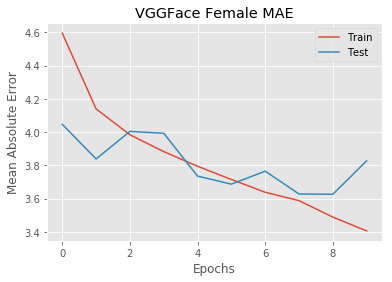

In [12]:
graph_MAE(history_vgg_age, 'VGGFace Female MAE')

### Male

In [38]:
model_male = Sequential()
model_male.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model_male.add(Convolution2D(64, (3, 3), activation='relu'))
model_male.add(ZeroPadding2D((1,1)))
model_male.add(Convolution2D(64, (3, 3), activation='relu'))
model_male.add(MaxPooling2D((2,2), strides=(2,2)))
 
model_male.add(ZeroPadding2D((1,1)))
model_male.add(Convolution2D(128, (3, 3), activation='relu'))
model_male.add(ZeroPadding2D((1,1)))
model_male.add(Convolution2D(128, (3, 3), activation='relu'))
model_male.add(MaxPooling2D((2,2), strides=(2,2)))
 
model_male.add(ZeroPadding2D((1,1)))
model_male.add(Convolution2D(256, (3, 3), activation='relu'))
model_male.add(ZeroPadding2D((1,1)))
model_male.add(Convolution2D(256, (3, 3), activation='relu'))
model_male.add(ZeroPadding2D((1,1)))
model_male.add(Convolution2D(256, (3, 3), activation='relu'))
model_male.add(MaxPooling2D((2,2), strides=(2,2)))
 
model_male.add(ZeroPadding2D((1,1)))
model_male.add(Convolution2D(512, (3, 3), activation='relu'))
model_male.add(ZeroPadding2D((1,1)))
model_male.add(Convolution2D(512, (3, 3), activation='relu'))
model_male.add(ZeroPadding2D((1,1)))
model_male.add(Convolution2D(512, (3, 3), activation='relu'))
model_male.add(MaxPooling2D((2,2), strides=(2,2)))
 
model_male.add(ZeroPadding2D((1,1)))
model_male.add(Convolution2D(512, (3, 3), activation='relu'))
model_male.add(ZeroPadding2D((1,1)))
model_male.add(Convolution2D(512, (3, 3), activation='relu'))
model_male.add(ZeroPadding2D((1,1)))
model_male.add(Convolution2D(512, (3, 3), activation='relu'))
model_male.add(MaxPooling2D((2,2), strides=(2,2)))
 
model_male.add(Convolution2D(4096, (7, 7), activation='relu'))
model_male.add(Dropout(0.5))
model_male.add(Convolution2D(4096, (1, 1), activation='relu'))
model_male.add(Dropout(0.5))
model_male.add(Convolution2D(2622, (1, 1)))
model_male.add(Flatten())

model_male.load_weights('../weights/vgg_face_weights.h5')

model_male.pop()
model_male.pop()
model_male.pop()
model_male.pop()
model_male.pop()
model_male.pop()

model_male.add(GlobalAveragePooling2D())
model_male.add(Dense(1024, activation = 'relu'))
model_male.add(Dropout(0.5))
model_male.add(Dense(128, activation = 'relu'))
model_male.add(Dropout(0.5))
model_male.add(Dense(1, activation= 'linear'))

# model_male.load_weights('../weights/vggface_male_age.h5')

for layer in model_male.layers[:17]:
    layer.trainable = False
    
model_male.summary()    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_52 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_53 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_54 (ZeroPaddi (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 112, 112, 128)     73856     
__________

In [8]:
opt = keras.optimizers.Adam()
model_male.compile(optimizer=opt, loss='mean_absolute_error', metrics=['mse'])

checkpoint = ModelCheckpoint('vggface_male_age.h5', monitor = 'val_loss', 
                             mode = 'min', save_best_only = True, verbose = 1)

earlystopping = EarlyStopping(monitor= 'val_loss', min_delta= 0, patience = 5, 
                              verbose = 1, restore_best_weights= True)

In [25]:
imggen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1/255.0,validation_split=0.2)

batch_size=32
filepath = '/home/ubuntu/data/AFAD-Full/AFAD_gender/male'
train_datagen_age_male = imggen.flow_from_directory(filepath, target_size=(224,224),batch_size=batch_size, 
                                           class_mode = 'sparse',subset='training', seed = 1)
validation_datagen_age_male = imggen.flow_from_directory(filepath, target_size=(224,224), batch_size=batch_size
                                                , class_mode = 'sparse', subset='validation', seed = 1)

Found 80608 images belonging to 26 classes.
Found 20137 images belonging to 26 classes.


In [26]:
# Find baseline - Always predict the mean age
y_train = np.array([])
for i in range(len(train_datagen_age_male)):
    y_train = np.append(y_train, train_datagen_age_male[i][1])
    
y_test = np.array([])
for i in range(len(validation_datagen_age_male)):
    y_test = np.append(y_test, validation_datagen_age_male[i][1])
    
mean_age_male = np.mean(y_train)
y_pred = np.full(y_test.shape, mean_age_male)

mean_absolute_error(y_test, y_pred)

5.131449115785926

In [10]:
# Use VGGFace. 
history_vgg_age_male = model_male.fit(train_datagen_age_male, batch_size=4, epochs=10, verbose=2,
                    validation_data = validation_datagen_age_male,callbacks=[earlystopping, checkpoint])

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
630/630 [==============================] - 2171s 3s/step - loss: 4.5542 - mean_squared_error: 36.8207

Epoch 00001: val_loss improved from inf to 4.55421, saving model to age_estimator_vgg_male.h5
 - 16130s - loss: 4.9118 - mean_squared_error: 47.7102 - val_loss: 4.5542 - val_mean_squared_error: 36.8207
Epoch 2/10
630/630 [==============================] - 2171s 3s/step - loss: 3.9996 - mean_squared_error: 27.8735

Epoch 00002: val_loss improved from 4.55421 to 3.99964, saving model to age_estimator_vgg_male.h5
 - 16112s - loss: 4.2595 - mean_squared_error: 30.4921 - val_loss: 3.9996 - val_mean_squared_error: 27.8735
Epoch 3/10
630/630 [==============================] - 2175s 3s/step - loss: 4.0311 - mean_squared_error: 24.8747

Epoch 00003: val_loss did not improve from 3.99964
 - 16096s - loss: 4.0392 - mean_squared_error: 27.8178 - val_loss: 4.0311 - val_mean_squared_error: 24.8747
Epoch 4/10
630/630 [=======================

KeyboardInterrupt: 

Interrupted the kernel on purpose due to time constraint.

In [13]:
# Manually create the history log since I stopped the training
history_vgg_age_male = {'loss': [4.9118,  4.2595, 4.0392, 3.8796, 3.7620, 3.6710],
 'mean_squared_error': [47.7102,  30.4921, 27.8178, 25.9392, 24.6484, 23.7064],
 'val_loss': [4.5542,  3.9996, 4.0311, 3.7472, 3.6062, 3.5806],
 'val_mean_squared_error': [36.8207,  27.8735, 24.8747, 24.7119, 22.3691, 21.4636]}

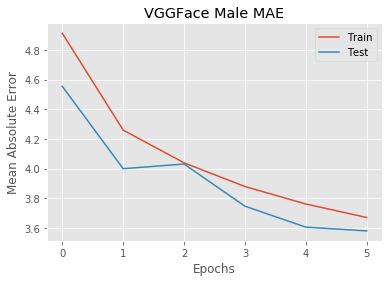

In [17]:
graph_MAE(history_vgg_age_male, 'VGGFace Male MAE')

### Compare models 

In [43]:
true_pred_df_male = get_ytrue_ypred(model_male,validation_datagen_age_male)
true_pred_df_female = get_ytrue_ypred(model,validation_datagen_age)

mae_female = get_average_MAE(true_pred_df=true_pred_df_female)
mae_male = get_average_MAE(true_pred_df=true_pred_df_male)

Text(0.5, 1.0, 'Average MAE - Male vs Female')

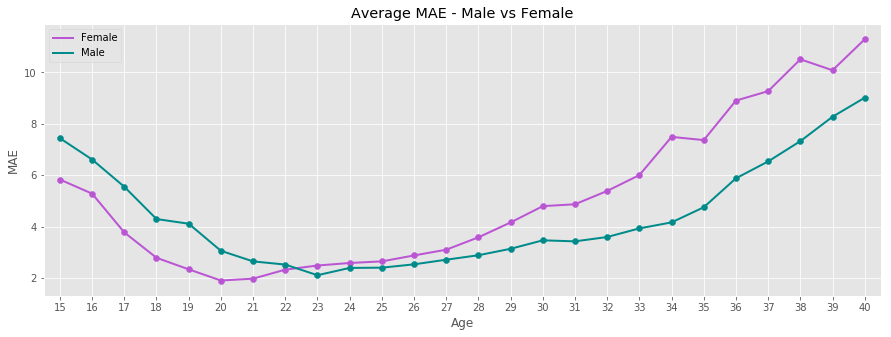

In [44]:
fig, ax = plt.subplots(figsize = (15,5))
ages = np.arange(15,41)
ax.plot(ages, mae_female, color = 'mediumorchid',linewidth = 2,label = 'Female')
ax.scatter(ages, mae_female,c='mediumorchid')
ax.plot(ages, mae_male,color ='darkcyan' ,linewidth = 2,label = 'Male')
ax.scatter(ages, mae_male,c='darkcyan')
ax.set_xticks(ages)
ax.legend()
ax.set_xlim(left = 14.5, right = 40.5)
ax.set_xlabel('Age')
ax.set_ylabel('MAE')
ax.set_title('Average MAE - Male vs Female')